In [1]:
# Import all function definitions
from functions_only import *


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import Counter, defaultdict
import community as community_louvain
import igraph as ig
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import random


In [3]:



# -----------------------------
# Load edge list
# -----------------------------
edges = pd.read_csv("lastfm_asia_edges.csv")
nodes = pd.read_csv("lastfm_asia_target.csv")

# -----------------------------
# Load raw music features (JSON)
# -----------------------------
with open("lastfm_asia_features.json", "r") as f:
    raw_features = json.load(f)

raw_features = {int(k): v for k, v in raw_features.items()}


# -----------------------------
# Convert artist lists -> feature vectors
# -----------------------------
node_ids = nodes["id"].values
artist_lists = [raw_features[n] for n in node_ids]

mlb = MultiLabelBinarizer(sparse_output=False)
X = mlb.fit_transform(artist_lists)

features = {node_ids[i]: X[i] for i in range(len(node_ids))}

# -----------------------------
# Create undirected graph
# -----------------------------
G = nx.Graph()

for _, row in edges.iterrows():
    G.add_edge(row["node_1"], row["node_2"])

gender_dict = dict(zip(nodes["id"], nodes["target"]))
nx.set_node_attributes(G, gender_dict, name="gender")


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Feature vector dimension:", X.shape[1])




Number of nodes: 7624
Number of edges: 27806
Feature vector dimension: 7842


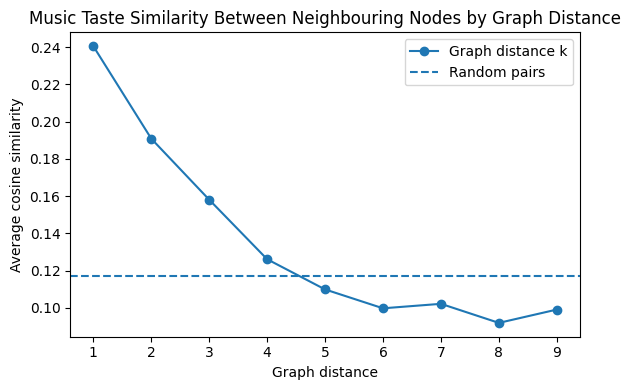

In [8]:
sims = distance_k_cosine_similarity(
    G,
    features,
    max_dist=10,
    n_samples=500
)

# mean values from your output
distances = [1, 2, 3, 4, 5,6,7,8,9]
means = [
    sims[1].mean(),
    sims[2].mean(),
    sims[3].mean(),
    sims[4].mean(),
    sims[5].mean(),
    sims[6].mean(),
    sims[7].mean(),
    sims[8].mean(),
    sims[9].mean()
]

random_mean = sims["random"].mean()

plt.figure(figsize=(6, 4))

plt.plot(distances, means, marker="o", label="Graph distance k")
plt.axhline(
    y=random_mean,
    linestyle="--",
    label="Random pairs"
)

plt.xlabel("Graph distance")
plt.ylabel("Average cosine similarity")
plt.title("Music Taste Similarity Between Neighbouring Nodes by Graph Distance")

plt.xticks(distances)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
N = G.number_of_nodes()
M = G.number_of_edges()
avg_degree = sum(dict(G.degree()).values()) / N

print("Average degree:", avg_degree)


Average degree: 7.2943336831059815


In [10]:
avg_clustering = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering)


Average clustering coefficient: 0.219418424327086


In [11]:
# Use largest connected component
if not nx.is_connected(G):
    Gc = G.subgraph(max(nx.connected_components(G), key=len))
else:
    Gc = G

avg_path_length = nx.average_shortest_path_length(Gc)
diameter = nx.diameter(Gc)

print("Average path length:", avg_path_length)
print("Diameter:", diameter)


Average path length: 5.232237268915701
Diameter: 15


In [12]:
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity:", assortativity)


Degree assortativity: 0.017073172560631417


Top 5 communities: [1, 10, 7, 2, 4]


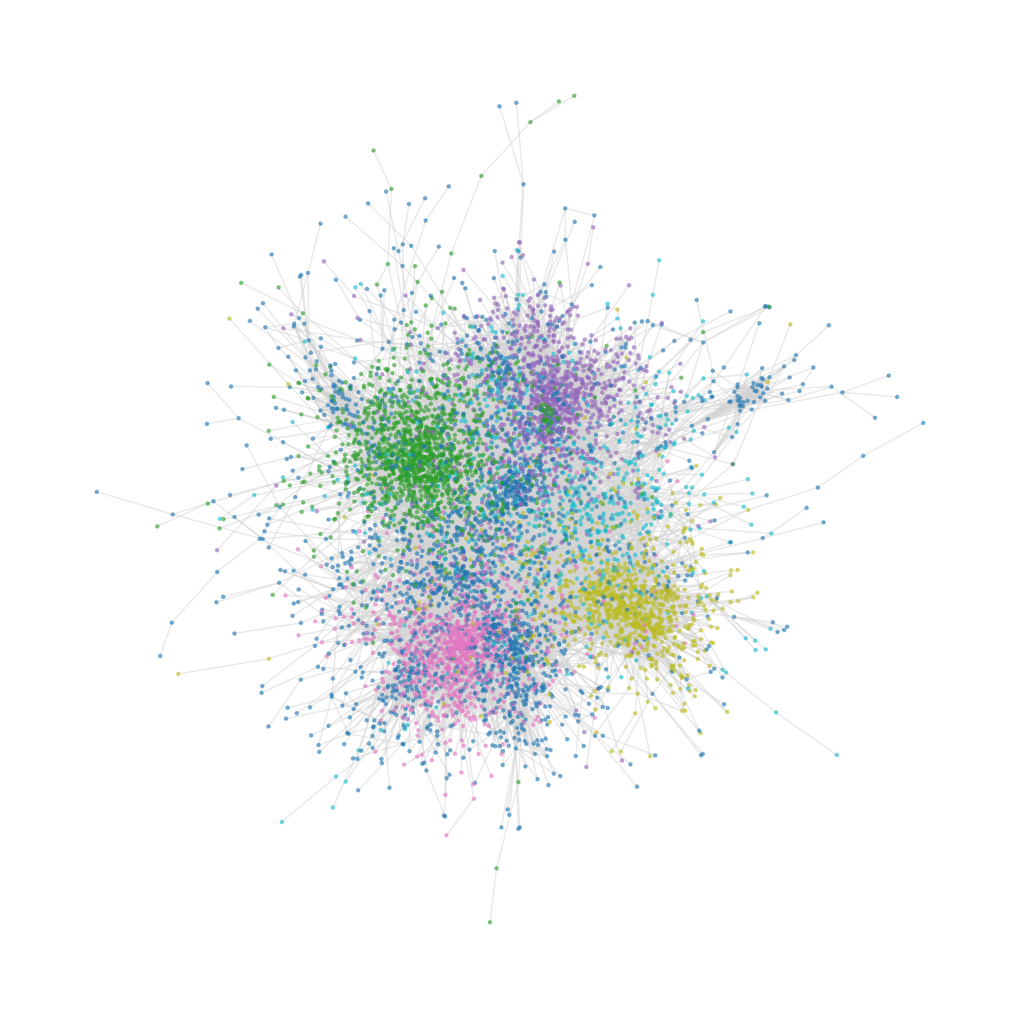

In [13]:

nodes = list(G.nodes())
node_to_idx = {node: i for i, node in enumerate(nodes)}

edges_ig = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
G_ig = ig.Graph(edges=edges_ig, directed=False)

partition_louvain = G_ig.community_multilevel()

membership = partition_louvain.membership


# -----------------------------
community_sizes = Counter(membership)
top5 = [cid for cid, _ in community_sizes.most_common(5)]

# -----------------------------
# 4. Assign colors
#    top 5 -> 0..4
#    others -> -1 (gray)
# -----------------------------
node_colors = []
for node in nodes:
    cid = membership[node_to_idx[node]]
    if cid in top5:
        node_colors.append(top5.index(cid))
    else:
        node_colors.append(-1)

# -----------------------------
# 5. Plot network
# -----------------------------
pos = nx.spring_layout(G,seed=42)

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    node_size=5,
    node_color=node_colors,
    cmap=plt.cm.tab10,   
    edge_color="lightgray",
    alpha=0.5,
    vmin=-1,
    vmax=4
)
#plt.title("Top 5 Louvain Communities (others in gray)")
plt.show()


In [14]:
# Modularity of the Louvain partition
modularity = partition_louvain.modularity

print(f"Modularity of Louvain partition: {modularity:.4f}")


Modularity of Louvain partition: 0.8135


In [15]:

# -----------------------------
# Community statistics
# -----------------------------
community_sizes = Counter(membership)

num_communities = len(community_sizes)
total_nodes = len(membership)

top5 = [cid for cid, _ in community_sizes.most_common(5)]
top5_sizes = [community_sizes[cid] for cid in top5]

covered_nodes = sum(top5_sizes)
coverage_pct = 100 * covered_nodes / total_nodes

print(f"Total number of communities: {num_communities}")
print("Top 5 communities (community id : size):")
for cid, size in zip(top5, top5_sizes):
    print(f"  Community {cid}: {size} nodes")

print(f"Top 5 communities cover {covered_nodes} / {total_nodes} nodes "
      f"({coverage_pct:.2f}%)")


Total number of communities: 28
Top 5 communities (community id : size):
  Community 1: 1487 nodes
  Community 10: 1154 nodes
  Community 7: 1011 nodes
  Community 2: 935 nodes
  Community 4: 623 nodes
Top 5 communities cover 5210 / 7624 nodes (68.34%)


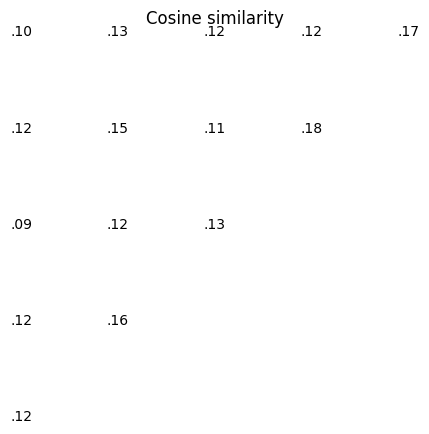

In [17]:
community_sizes = Counter(membership)
top5_comms = [cid for cid, _ in community_sizes.most_common(5)]

labels_louvain = {
    node: membership[node_to_idx[node]]
    for node in nodes
    if membership[node_to_idx[node]] in top5_comms
}

nodes_top5_louvain = list(labels_louvain.keys())

M_top5, comm_ids = sampled_group_cosine_matrix(
    nodes=nodes_top5_louvain,
    features=features,
    labels=labels_louvain,
    samples_per_pair=500
)


Top 5 countries: [17, 10, 0, 6, 14]


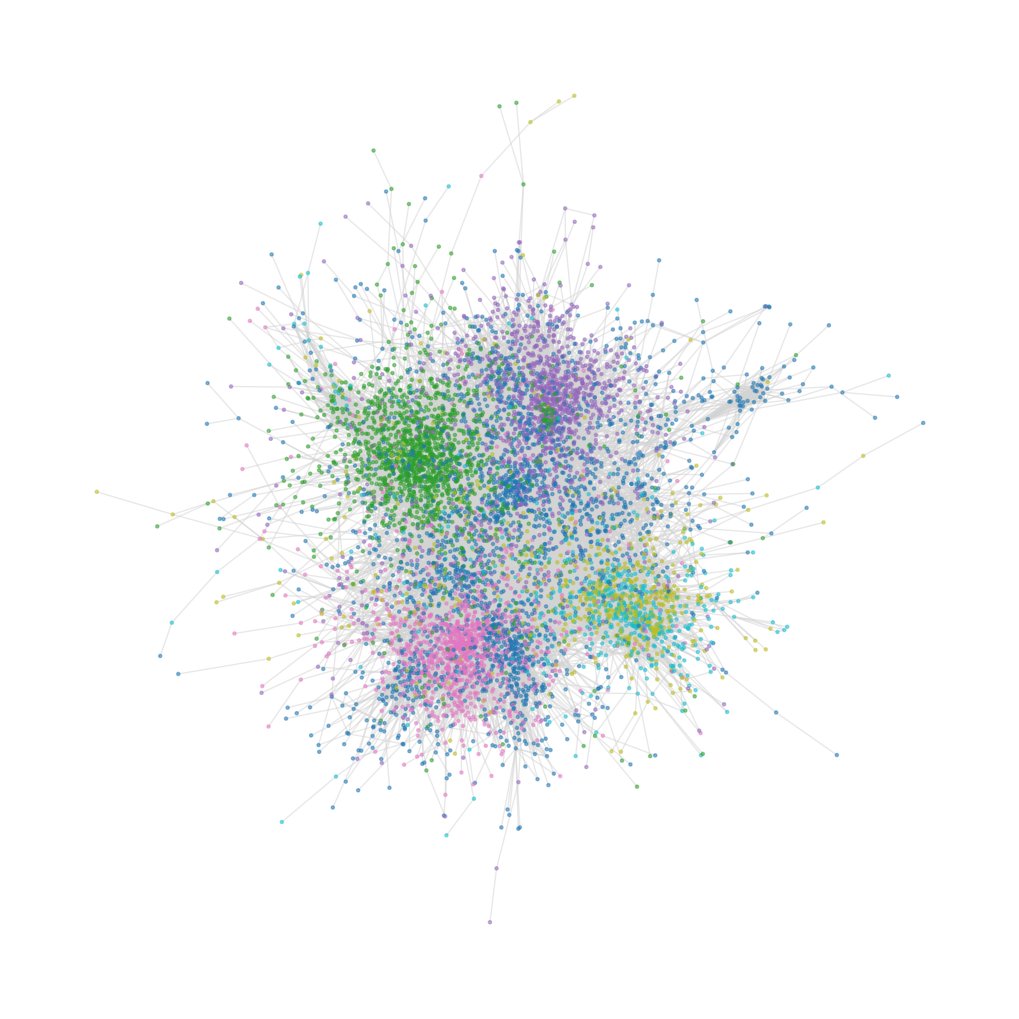

In [18]:
df = pd.read_csv("lastfm_asia_target.csv")
country = dict(zip(df["id"], df["target"]))

nodes = list(G.nodes())

# -----------------------------
# Find top 5 countries by size
# -----------------------------
country_counts = Counter(country.values())
top5_countries = [c for c, _ in country_counts.most_common(5)]

print("Top 5 countries:", top5_countries)

# -----------------------------
# Assign colors
#   top 5 -> 0..4
#   others -> -1 (gray)
# -----------------------------
node_colors = []
for node in nodes:
    c = country[node]
    if c in top5_countries:
        node_colors.append(top5_countries.index(c))
    else:
        node_colors.append(-1)

# -----------------------------
# Plot
# -----------------------------
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    node_size=5,
    node_color=node_colors,
    cmap=plt.cm.tab10,   # enough colors for 5
    edge_color="lightgray",
    alpha=0.5,
    vmin=-1,
    vmax=4
)
#plt.title("Network colored by top 5 countries (others in gray)")
plt.show()

In [19]:
df = pd.read_csv("lastfm_asia_target.csv")

country_sizes = df["target"].value_counts().sort_index()
print(country_sizes)

target
0     1098
1       54
2       73
3      515
4       16
5      391
6      655
7       82
8      468
9       58
10    1303
11     138
12      57
13      63
14     570
15     257
16     254
17    1572
Name: count, dtype: int64


In [22]:

# Count how many nodes per color (ignore -1)
color_counts = Counter(c for c in node_colors if c != -1)
nodes = list(G.nodes())
# Get the 5 most common colors
top5_colors = [c for c, _ in color_counts.most_common(5)]


country_labels = {
    node: node_colors[i]
    for i, node in enumerate(nodes)
    if node_colors[i] in top5_colors
}

nodes_top5 = list(country_labels.keys())

print("#Nodes in top 5 communities:", len(nodes_top5))


#Nodes in top 5 communities: 5198


{1: {0: 0.7225433526011561, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 2.0953757225433525, 7: 0.0, 8: 0.0, 9: 0.0, 10: 1.300578034682081, 11: 0.0, 12: 0.0, 13: 0.0, 14: 1.5895953757225434, 15: 0.0, 16: 0.0, 17: 94.29190751445087}, 2: {0: 0.6637168141592921, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 49.00442477876106, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.6637168141592921, 11: 0.0, 12: 0.0, 13: 0.0, 14: 47.34513274336283, 15: 0.0, 16: 0.0, 17: 2.3230088495575223}, 7: {0: 93.7246963562753, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 3.1376518218623484, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.8097165991902834, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.9109311740890689, 15: 0.0, 16: 0.0, 17: 1.417004048582996}, 4: {0: 2.380952380952381, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 19.047619047619047, 7: 0.0, 8: 0.0, 9: 0.0, 10: 26.19047619047619, 11: 0.0, 12: 0.0, 13: 0.0, 14: 11.904761904761905, 15: 0.0, 16: 0.0, 17: 40.476190476190474}, 10: {0: 0.5681818181818182, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.4204545

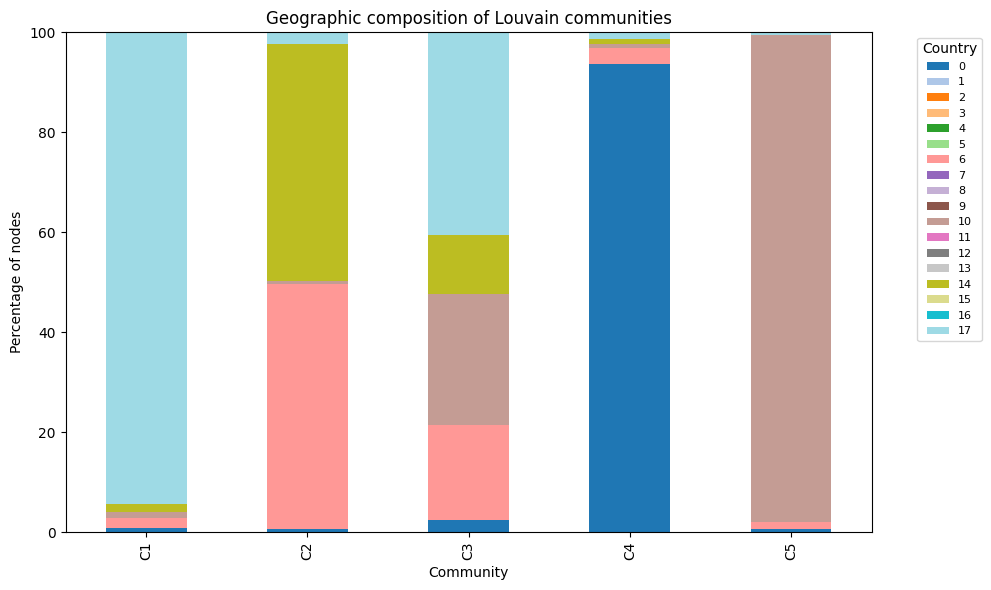

In [25]:
country_dist = community_country_percentages(
    nodes_top5,
    labels_louvain,
    country
)
print(country_dist)
plot_community_country_distribution(
    country_dist
)

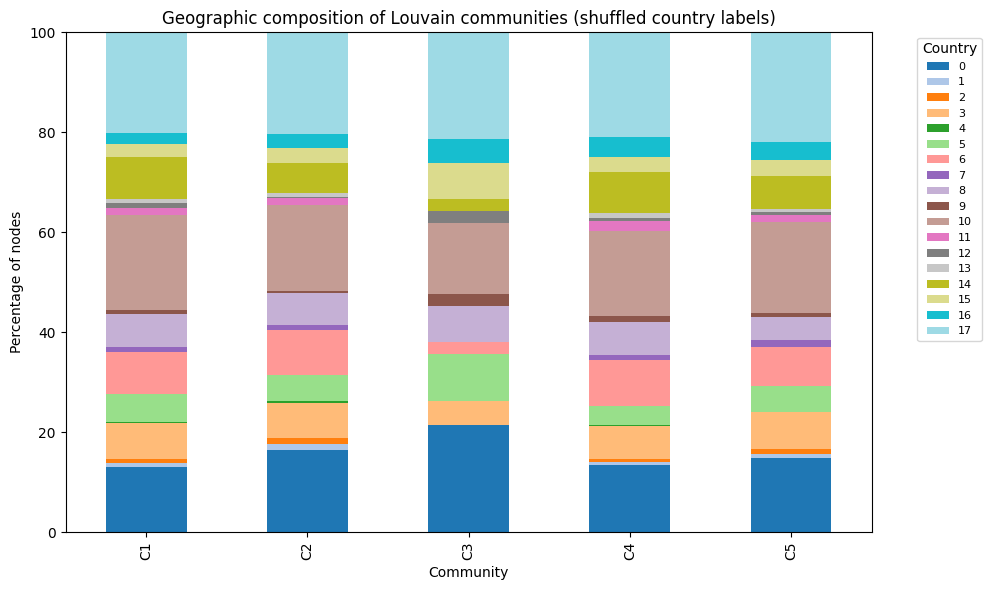

In [26]:
shuffle = shuffle_country_labels(country)
country_dist_shuffle = community_country_percentages(
    nodes_top5,
    labels_louvain,
    shuffle
)

plot_community_country_distribution(
   country_dist_shuffle,
    title="Geographic composition of Louvain communities (shuffled country labels)"
)

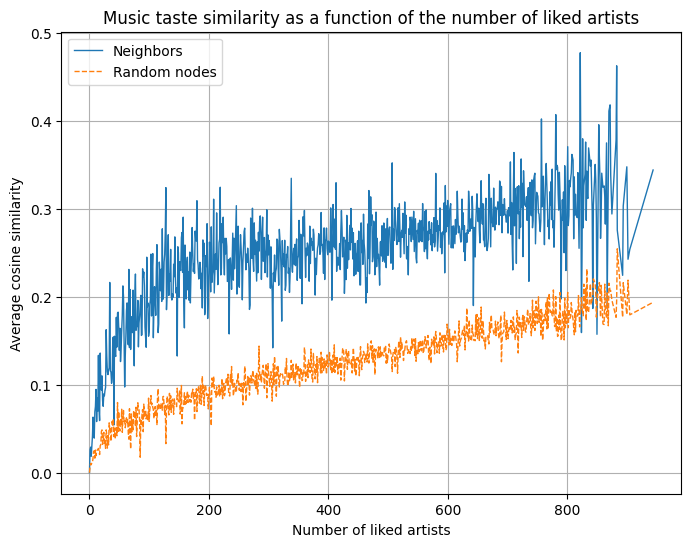

In [4]:
plot_num_artists_vs_avg_similarity(G, features)
